In [1]:
import psutil
from optmethods.first_order import RestNest
from data import W8a_dataset

from methods.local_sgd import *
from methods.fedlin import *
from methods.s_local_gd import *
from methods.scaffold import *
from methods.proxskip import *

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", context="talk", font_scale=1.2, palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'DejaVu Sans'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (11, 7)

In [3]:
num_cpus = psutil.cpu_count(logical=False)
print(num_cpus)

16


In [4]:
dataset = W8a_dataset(num_cpus)

Computing the smoothness constant via SVD, it may take a few minutes...
L: 0.6610997571596956, l2: 6.610997571596957e-05


# Nesterov's Method

  0%|          | 0/10000 [00:00<?, ?it/s]

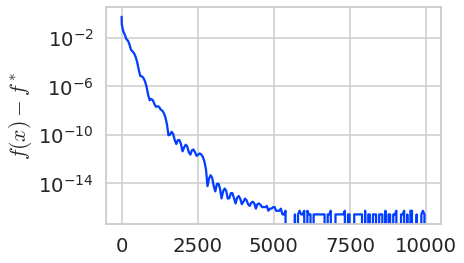

In [5]:
loss, x0,  _, _ = dataset.get_full_data()
rest = RestNest(loss=loss, doubling=True)
rest_tr = rest.run(x0=x0, it_max=10000)
rest_tr.compute_loss_of_iterates()
rest.trace.plot_losses()

plt.yscale('log')

# Non-iid

In [6]:
cohort_size = 20 # CHANGE IF YOU WANT PARTIAL PARTICIPATION
n_workers = 20
n_seeds = 1
batch_size = None

L = loss.smoothness
l2 = 1e-4 * L

In [7]:
GLOBAL_it_max_ = 1000

In [8]:
losses = dataset.get_splitted_data(n_workers)
grad_norms = [np.linalg.norm(loss_i.gradient(loss.x_opt))**2 for loss_i in losses]
print(np.mean(grad_norms))

0.0027313946205275337


/home/v_trofinov/anaconda3/lib/python3.9/site-packages/optmethods/loss/logistic_regression.py:44: UserWarning: The labels have only one unique value.
  warnings.warn('The labels have only one unique value.')


### Local GD

In [9]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = GLOBAL_it_max_
    skip_decay_coef = l2 / 2
else:
    it_local = 100 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness*it_local)
    it_max = GLOBAL_it_max_ # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
localgd1 = LocalSgd(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
localgd1.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
localgd1.trace.compute_loss_of_iterates()
localgd1.terminate_workers()

2023-12-21 19:42:42,905	INFO worker.py:1673 -- Started a local Ray instance.


  0%|          | 0/1000 [00:00<?, ?it/s]

### FedLin

In [10]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = GLOBAL_it_max_
    skip_decay_coef = l2 / 2
else:
    it_local = 100 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness*it_local)
    it_max = GLOBAL_it_max_ # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
fedlin1 = Fedlin(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
fedlin1.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
fedlin1.trace.compute_loss_of_iterates()
fedlin1.terminate_workers()

  0%|          | 0/1000 [00:00<?, ?it/s]

### Scaffold

In [11]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = GLOBAL_it_max_
    skip_decay_coef = l2 / 2
else:
    it_local = 100 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness*it_local)
    it_max = GLOBAL_it_max_ # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
scaf = Scaffold(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
scaf.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
scaf.trace.compute_loss_of_iterates()
scaf.terminate_workers()

  0%|          | 0/1000 [00:00<?, ?it/s]

### S-local-GD

In [12]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = GLOBAL_it_max_
    skip_decay_coef = l2 / 2
else:
    it_local = 100 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness*it_local)
    it_max = GLOBAL_it_max_ # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize

skip_lr_max = skip_lr0
slocalgd = S_local_GD(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)
slocalgd.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
slocalgd.trace.compute_loss_of_iterates()
slocalgd.terminate_workers()

  0%|          | 0/1000 [00:00<?, ?it/s]

### ProxSkip

In [15]:
if batch_size is not None:
    it_local = 100
    skip_lr0 = 1 / loss.batch_smoothness(batch_size=batch_size) 
    it_max = GLOBAL_it_max_
    skip_decay_coef = l2 / 2
    proba = np.sqrt(loss.l2 / loss.batch_smoothness(batch_size=batch_size))
else:
    it_local = 100 # same as for other methods
    skip_lr0 = 1 / (loss.smoothness)
    it_max = GLOBAL_it_max_ # same as before
    skip_decay_coef = 0. # With full gradients, we don't need to decrease the stepsize
    proba = np.sqrt(loss.l2 / loss.smoothness)


skip_lr_max = skip_lr0
skip = ProxSkip(loss=loss, n_workers=n_workers, cohort_size=cohort_size, it_local=it_local, 
               lr_max=skip_lr_max, lr0=skip_lr0, lr_decay_coef=skip_decay_coef, 
               it_start_decay=0, n_seeds=n_seeds, batch_size=batch_size, trace_len=200, iid=False, losses=losses)

skip.proba = proba

skip.run(x0=x0, it_max=it_max)
# sgd.trace.convert_its_to_epochs(batch_size=batch_size*it_local)
skip.trace.compute_loss_of_iterates()
skip.terminate_workers()

  0%|          | 0/1000 [00:00<?, ?it/s]

### Plots

In [2]:
skip.trace.plot_losses(label='ProxSkip', marker='*', color='red')
slocalgd.trace.plot_losses(label='S-local-GD', marker='*', color='blue')
scaf.trace.plot_losses(label='SCAFFOLD', marker='*', color='green')
fedlin1.trace.plot_losses(label='FedLin', marker='*', color='orange')
localgd1.trace.plot_losses(label='Local GD', marker='*', color='black')
plt.yscale('log')
plt.ylabel(r'$f(x)-f_*$')
plt.xlabel('Communication rounds')
plt.legend()
plt.savefig('GD_comparison.pdf')

NameError: name 'skip' is not defined